In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.layers import Input, Embedding, Add, Dot, Flatten
from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam, SGD
import pydot
from tensorflow.keras.utils import model_to_dot
from IPython.display import SVG
from operator import itemgetter
from sklearn.decomposition import PCA
%matplotlib inline

2.8.0


In [ ]:
!pip3 install pickle5
import pickle5 as pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import time

start = time.time()
reviews_path='/content/drive/MyDrive/yelp_dataset/reviews_df.pkl'
final_path='/content/drive/MyDrive/yelp_dataset/final_df.pkl'
user_path= '/content/drive/MyDrive/yelp_dataset/user_df.pkl'
business_path = '/content/drive/MyDrive/yelp_dataset/business_df.pkl'

with open(reviews_path, "rb") as fh:
  reviews_df = pickle.load(fh)
end = time.time()
print(f'Total time: {end-start}')

Total time: 41.0090217590332


In [ ]:
with open(final_path, "rb") as fh:
  final_df = pickle.load(fh)

with open(user_path, "rb") as fh:
  user_df = pickle.load(fh)

with open(business_path, "rb") as fh:
  business_df = pickle.load(fh)

In [ ]:
reviews_df.head(2)

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
1,8bFej1QE5LXp4O05qjGqXA,0,0,4.0,1,0,0,This store is pretty good. Not as great as Wal...,2015-07-03 20:38:25
3,T5fAqjjFooT4V0OeZyuk1w,1,1,2.0,1,1,1,I've stayed at many Marriott and Renaissance M...,2010-01-08 02:29:15


In [ ]:
user_df.head(2)

,user_id,name,review_count,yelping_since,useful,funny,cool,elite,friends,fans,average_stars,compliment_hot,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,0,Jane,1220,2005-03-14 20:26:35,15038,10030,11291,"2006,2007,2008,2009,2010,2011,2012,2013,2014",[463996],1357,3.85,1710,163,190,361,147,1212,5691,2541,2541,815,323
1,1,Gabi,2136,2007-08-10 19:01:51,21272,10289,18046,"2007,2008,2009,2010,2011,2012,2013,2014,2015,2...",[],1025,4.09,1632,87,94,232,96,1187,3293,2205,2205,472,294


In [ ]:
final_df.head(2)

,user_id,business_id,stars
1,0,0,4.0
3,1,1,2.0


In [ ]:
final_df.shape

(4725630, 3)

In [ ]:
n_users=final_df.user_id.nunique()
n_users

1427394

In [ ]:
n_items=final_df.business_id.nunique()
n_items

41768

In [ ]:
n_users*n_items

59619392592

Setting up the model

In [ ]:
np.random.seed=2017
train_indices, val_indices = train_test_split(range(final_df.shape[0]), train_size=0.8)
trdf = final_df.iloc[train_indices]
valdf = final_df.iloc[val_indices]
trdf.shape, valdf.shape

((3780504, 3), (945126, 3))

In [ ]:
#Defining size of the latent factors or the embeddings & the amount of regularization.
L = 50
REG=5e-4

In [ ]:
def create_bias(name, inp, n_in, reg):
    x = Embedding(n_in, 1, input_length=1, name=name)(inp)
    return Flatten(name=name+'_flat')(x)

In [ ]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape=(1,), dtype='int64', name=name)
    return inp, Embedding(n_in, n_out, input_length=1, name=name.split('_')[0]+'_factor', embeddings_regularizer=l2(reg))(inp)

In [ ]:
user_input, uLmat = embedding_input('user_input', n_users, L, REG)
biz_input, bLmat = embedding_input('Biz_input', n_items, L, REG)

In [ ]:
user_input.shape, biz_input.shape

(TensorShape([None, 1]), TensorShape([None, 1]))

In [ ]:
uLmat.shape, bLmat.shape

(TensorShape([None, 1, 50]), TensorShape([None, 1, 50]))

In [ ]:
user_bias = create_bias('user_bias', user_input, n_users, REG)
biz_bias = create_bias('biz_bias', biz_input, n_items, REG)

In [ ]:
user_bias.shape, biz_bias.shape

(TensorShape([None, 1]), TensorShape([None, 1]))

In [ ]:
residual = Dot(axes=2, name="residual")([uLmat, bLmat])

In [ ]:
residual.shape

TensorShape([None, 1, 1])

In [ ]:
residflat = Flatten(name="residual_flat")(residual)
residflat.shape

TensorShape([None, 1])

In [ ]:
regression = Add(name="regression")([user_bias, biz_bias, residflat])

In [ ]:
def sigmoid_maker(low, high):
    def custom_sigmoid(x):
        return K.sigmoid(x)*(high - low) + low
    return custom_sigmoid

In [ ]:
cs = sigmoid_maker(0, 5.5)

In [ ]:
output = Activation(cs, name="Sigmoid_Range")(regression)

In [ ]:
model = Model([user_input, biz_input], output)
model.compile(SGD(0.001), loss='mse')

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Biz_input (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 user_factor (Embedding)        (None, 1, 50)        71369700    ['user_input[0][0]']             
                                                                                                  
 Biz_factor (Embedding)         (None, 1, 50)        2088400     ['Biz_input[0][0]']              
                                                                                              

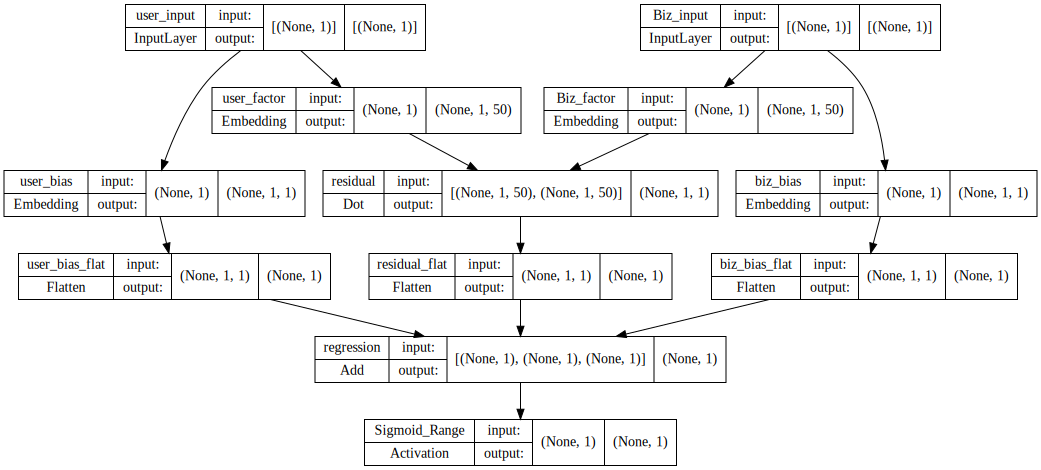

In [ ]:
SVG(model_to_dot(model,  show_shapes=True, show_layer_names=True, dpi=72, rankdir='TB').create_svg())

In [ ]:
trdf.business_id.shape

(3780504,)

Training the Model

In [ ]:
model.optimizer.lr=0.01
model.fit([trdf.user_id, trdf.business_id], trdf.stars, batch_size=10000, epochs=1, 
          validation_data=([valdf.user_id, valdf.business_id], valdf.stars))

379/379 [==============================] - 232s 609ms/step - loss: 33.4538 - val_loss: 33.3346


In [ ]:
model.optimizer.lr=0.001
model.fit([trdf.user_id, trdf.business_id], trdf.stars, batch_size=100000, epochs=1, 
          validation_data=([valdf.user_id, valdf.business_id], valdf.stars))

38/38 [==============================] - 27s 699ms/step - loss: 33.3337 - val_loss: 33.3323


In [ ]:
model.save_weights("m1.h5")

Making Predictions

In [ ]:
final_df.head()

,user_id,business_id,stars
1,0,0,4.0
3,1,1,2.0
5,2,2,1.0
7,3,3,5.0
12,4,4,4.0


In [ ]:
#Checking sample predictions
for i in range(5):
  k=model.predict([np.array([i]), np.array([i])]).ravel()
  print(i,k)

0 [2.8157778]
1 [2.6862152]
2 [2.798089]
3 [2.8376317]
4 [2.7453072]


In [ ]:
dfpreds = final_df[['business_id', 'stars', 'user_id']].copy()
dfpreds['predictions'] = model.predict([dfpreds.user_id, dfpreds.business_id]).ravel()

In [ ]:
dfpreds.head()

,business_id,stars,user_id,predictions
1,0,4.0,0,2.815778
3,1,2.0,1,2.686215
5,2,1.0,2,2.798089
7,3,5.0,3,2.837632
12,4,4.0,4,2.745307


Text(0, 0.5, 'prediction')

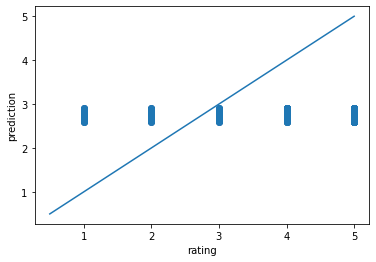

In [ ]:
plt.scatter(dfpreds.stars, dfpreds.predictions, alpha=0.05)
plt.plot([0.5,5],[0.5,5])
plt.xlabel("rating")
plt.ylabel("prediction")

In [ ]:
preds_stats=dfpreds.groupby('stars')['predictions'].describe().reset_index()
preds_stats

,stars,count,mean,std,min,25%,50%,75%,max
0,1.0,532466.0,2.750479,0.056610,2.589926,2.709891,2.750478,2.791032,2.908313
1,2.0,402999.0,2.750828,0.056729,2.589012,2.710118,2.750851,2.791440,2.912165
2,3.0,571174.0,2.751555,0.056675,2.593540,2.711105,2.751622,2.792208,2.913989
3,4.0,1202288.0,2.751283,0.056650,2.590740,2.711287,2.751854,2.792527,2.919708
4,5.0,2016703.0,2.751758,0.056673,2.589012,2.711102,2.751822,2.792350,2.917819


In [ ]:
preds_stats_train = dfpreds.iloc[train_indices].groupby('stars')['predictions'].describe().reset_index()
preds_stats_train

,stars,count,mean,std,min,25%,50%,75%,max
0,1.0,426073.0,2.750518,0.056574,2.589926,2.709914,2.750406,2.790958,2.908313
1,2.0,322439.0,2.750796,0.056698,2.589012,2.710158,2.750808,2.791334,2.910094
2,3.0,457075.0,2.751674,0.056630,2.593540,2.711198,2.751693,2.792164,2.913989
3,4.0,961452.0,2.751680,0.056650,2.590740,2.711334,2.751909,2.792542,2.919708
4,5.0,1613465.0,2.751612,0.056689,2.590140,2.711080,2.751828,2.792362,2.917819


In [ ]:
preds_stats_val = dfpreds.iloc[val_indices].groupby('stars')['predictions'].describe().reset_index()
preds_stats_val

,stars,count,mean,std,min,25%,50%,75%,max
0,1.0,106393.0,2.750535,0.056763,2.594060,2.709804,2.750751,2.791322,2.906374
1,2.0,80560.0,2.750913,0.056865,2.597923,2.709938,2.751002,2.791894,2.912165
2,3.0,114099.0,2.751424,0.056856,2.597849,2.710733,2.751369,2.792390,2.913178
3,4.0,240836.0,2.751676,0.056662,2.594920,2.711108,2.751627,2.792472,2.915961
4,5.0,403238.0,2.751819,0.056690,2.589012,2.711183,2.751801,2.792306,2.912410


Text(0, 0.5, 'prediction')

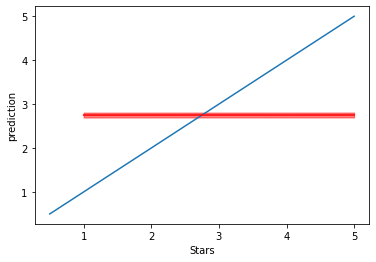

In [ ]:
plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats.stars, preds_stats['mean'], color="red")
plt.fill_between(preds_stats.stars, preds_stats['mean']-preds_stats['std'], preds_stats['mean']+preds_stats['std'], color="red", alpha=0.5)
plt.xlabel("Stars")
plt.ylabel("prediction")

Text(0.5, 1.0, 'val')

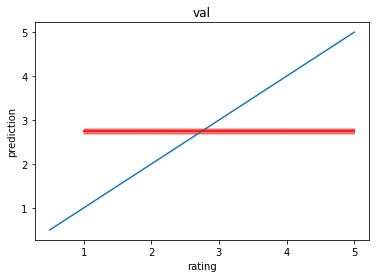

In [ ]:
plt.plot([0.5,5],[0.5,5])
plt.plot(preds_stats_val.stars, preds_stats_val['mean'], color="red")
plt.fill_between(preds_stats_val.stars, preds_stats_val['mean']-preds_stats_val['std'], preds_stats_val['mean']+preds_stats_val['std'], color="red", alpha=0.5)
plt.xlabel("rating")
plt.ylabel("prediction")
plt.title('val')

In [ ]:
ct = pd.crosstab(dfpreds.stars.astype('category'), 
                 dfpreds.predictions.apply(lambda x: round(x)).astype('category'))
ct.head()

predictions,3
stars,
1.0,532466
2.0,402999
3.0,571174
4.0,1202288
5.0,2016703


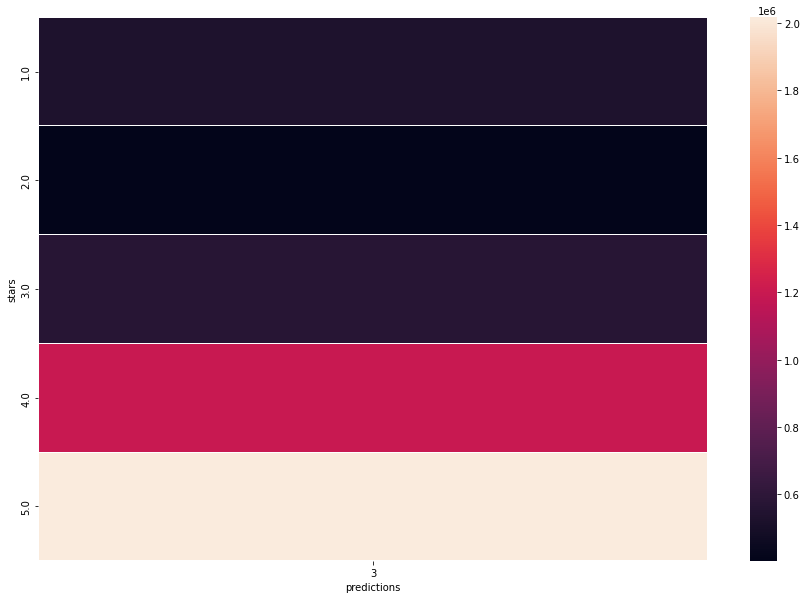

In [ ]:
plt.figure(figsize = (15,10))
sns.heatmap(ct, linewidths=0.1)

In [ ]:
final_df.head()

,user_id,business_id,stars
1,0,0,4.0
3,1,1,2.0
5,2,2,1.0
7,3,3,5.0
12,4,4,4.0


Making recommendations

In [ ]:
dfuser = final_df[(final_df.user_id==0)].sort_values('stars', ascending=False)
dfuser.head()

,user_id,business_id,stars
2351831,0,11726,5.0
6235944,0,31099,5.0
2913492,0,13605,5.0
2928145,0,15408,5.0
6176318,0,32288,5.0


In [ ]:
user0 = final_df[final_df.user_id==0]
user0=user0.copy()
user0.head()

,user_id,business_id,stars
1,0,0,4.0
12036,0,1826,5.0
32244,0,413,5.0
32616,0,2546,1.0
35687,0,2609,4.0


In [ ]:
biz_not_visited = list(set(final_df.business_id) - set(user0.business_id))

In [ ]:
len(biz_not_visited), len(set(user0.business_id))

(41376, 392)

In [ ]:
##Predictions on train data for user 0

user0['predictions'] = model.predict([user0.user_id, user0.business_id]).ravel()
user0.predictions=user0.predictions.apply(lambda x: round(x)).astype('category')
#Top rated predictions for user 0 (user_id==0)
user0=user0.sort_values('predictions',ascending=False)
user0.head()

,user_id,business_id,stars,predictions
1,0,0,4.0,3
12036,0,1826,5.0,3
5941528,0,28308,4.0,3
5928001,0,25246,5.0,3
5924024,0,28370,3.0,3


In [ ]:
biz_not_visited_df=pd.DataFrame(biz_not_visited, columns=['business_id'])
biz_not_visited_df['user_id'] =0

In [ ]:
##Predictions for not visited businesses for user 0

biz_not_visited_df['predictions'] = model.predict([biz_not_visited_df.user_id, biz_not_visited_df.business_id]).ravel()
biz_not_visited_df.predictions=biz_not_visited_df.predictions.apply(lambda x: round(x)).astype('category')
#Top rated predictions for user 0 (user_id==0)
biz_not_visited_df=biz_not_visited_df.sort_values('predictions',ascending=False)
biz_not_visited_df.head()

,business_id,user_id,predictions
0,1,0,3
27557,27823,0,3
27579,27845,0,3
27580,27847,0,3
27581,27848,0,3


In [ ]:
# Using the same model architecture as before and adding few dense layers
no_of_layers = 4
n = 32
activation='relu'
reg = 1e-2

dense = Add(name="regression")([user_bias, biz_bias, residflat])
for _ in range(no_of_layers):
  dense = Dense(n, activation=activation, kernel_regularizer=l2(reg))(dense)

output = Dense(1, activation=sigmoid_maker(0.5, 5.5), name="Sigmoid")(dense)

model_updated = Model([user_input, biz_input], output)
model_updated.compile(Adam(1e-2), loss='mse')

model_updated.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 user_input (InputLayer)        [(None, 1)]          0           []                               
                                                                                                  
 Biz_input (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 user_factor (Embedding)        (None, 1, 50)        71369700    ['user_input[0][0]']             
                                                                                                  
 Biz_factor (Embedding)         (None, 1, 50)        2088400     ['Biz_input[0][0]']              
                                                                                            

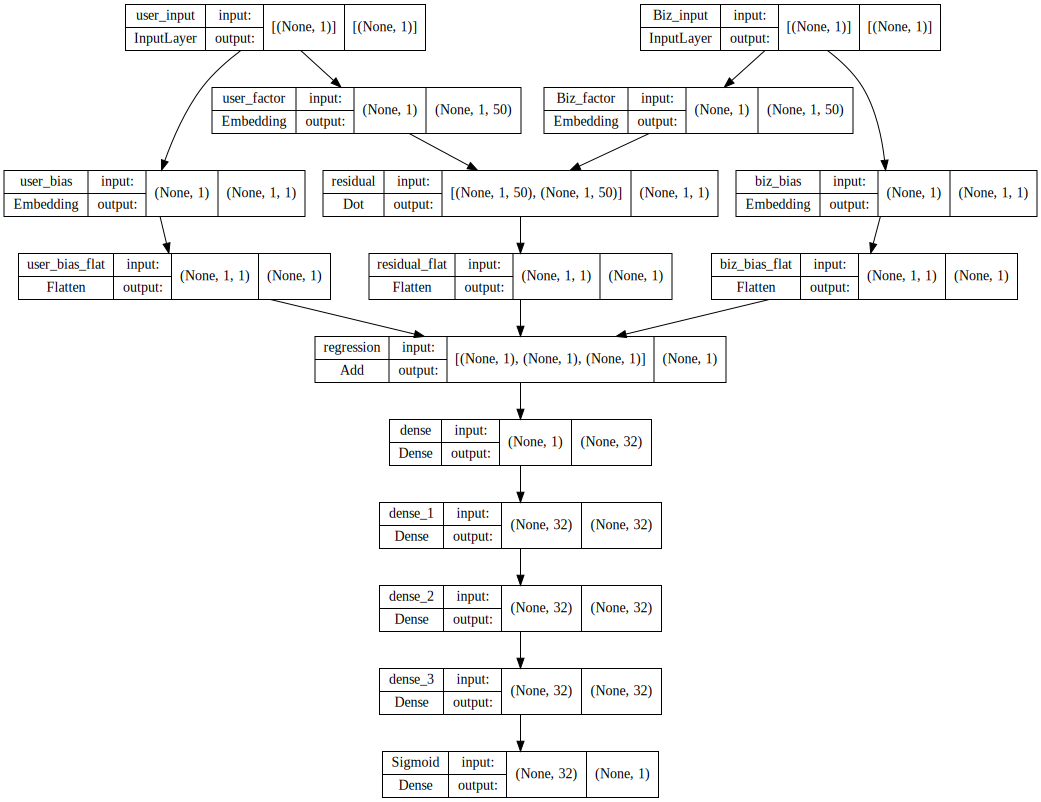

In [ ]:
SVG(model_to_dot(model_updated,  show_shapes=True, show_layer_names=True, dpi=72, rankdir='TB').create_svg())

In [ ]:
model_updated.optimizer.lr=0.001
model_updated.fit([trdf.user_id, trdf.business_id], trdf.stars, batch_size=100000, epochs=2, 
          validation_data=([valdf.user_id, valdf.business_id], valdf.stars))

Epoch 1/2
38/38 [==============================] - 40s 995ms/step - loss: 14.1957 - val_loss: 3.9076
Epoch 2/2
38/38 [==============================] - 38s 996ms/step - loss: 2.7231 - val_loss: 2.2880


In [ ]:
def get_restaurants(user_id):
  restaurant_list = []

  review_history = reviews_df.query(f'user_id=={user_id}')

  # If review history exists
  if(len(review_history)>0):
    business_history = business_df.query(f'business_id in {list(review_history.business_id)}')

    most_visited_cities = business_history.city.mode()

    for city in most_visited_cities:
      # Get list of restaurants that have atleast 100 reviews to get a more relevant restaurants 
      user_business_list = business_df.query(f'city == "{city}"  & review_count>100').sort_values(by='stars', ascending=False)[:20].business_id.values
      restaurant_list.extend(user_business_list)
    
  # Get recommendations from friends who have given atleast 100 reviews to get relevant restaurants 
  friends = user_df[user_df.user_id==user_id][user_df.review_count > 100].friends

  if(len(friends)>0):
    for friend in friends:
      # Get list of restaurants that the friend gave atleast 4 stars to
      friend_business_list = reviews_df.query(f'user_id=={friend} & stars>=4').business_id
      restaurant_list.extend(friend_business_list)
    
  return list(set(restaurant_list))


In [ ]:
def get_recommendations(user_id):
  restaurants = get_restaurants(user_id)
  ratings = model_updated.predict([np.array([user_id]*len(restaurants)), np.array(restaurants)])
  ratings = np.floor(ratings*2)/2
  pred_df = pd.DataFrame({'business_id':restaurants, 'predicted_ratings':ratings.ravel()}).query('predicted_ratings>=4')
  df = business_df[['business_id', 'name', 'address', 'city', 'stars','latitude','longitude']]
  return df.merge(pred_df, on='business_id')

In [ ]:
df=get_recommendations(0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [ ]:
df

,business_id,name,address,city,stars,latitude,longitude,predicted_ratings
0,6246,Rain or Shine Ice Cream,"1926 W 4th Avenue, Suite 102",Vancouver,4.5,49.268009,-123.14888,4.0


**Location of the recommended Restaurant**

In [ ]:
import folium
business_locations = df[["latitude", "longitude", "name"]]
map = folium.Map(location=[business_locations.latitude.mean(), business_locations.longitude.mean()], zoom_start=14, control_scale=True)

for index, location_info in business_locations.iterrows():
    folium.Marker([location_info["latitude"], location_info["longitude"]], popup=location_info["name"]).add_to(map)

map